A.S. Lundervold, 27.10.22

# Introduction

As we saw in the notebook `2.3.0-representations-CNNs-as-feature_extractors.ipynb`, a way to extract representations learned by a neural network is to attach hooks that grab information from one or more layers of the network.
<img src="https://upload.wikimedia.org/wikipedia/en/8/83/VGG_neural_network.png">

Such representations can then be combined with other information describing the data and task, and also be reused in other contexts. 

Let's try out these ideas on the molecules dataset from notebook `2.2.1-representations-representing_data_as_images-molecular_activity.ipynb`

# Setup

In [1]:
%matplotlib inline
import pandas as pd, numpy as np
from pathlib import Path

In [2]:
NB_DIR = Path.cwd()

DATA = NB_DIR/'data'/'drug'
RAWDATA = DATA/'raw'
INTERIMDATA = DATA/'interim'

# Path to image data as defined earlier
IMGDATA = Path('/data-ssd/molimages/')

In [3]:
from fastai.vision.all import *

# Load data

In [4]:
def get_df(data):
    """
    Construct a dataframe containing 
        CID, SMILES, Image, Activity
    """
    
    name = data.stem
    
    df = pd.read_csv(data)
    df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')
    
    df = df[['CID', 'SMILES', 'Image', 'Activity']]
    
    return df, name

We remember that we had 7 activity datasets:

In [5]:
# Datasets available:
data = sorted(list(RAWDATA.glob('CHEM*cl.csv')))
data

[Path('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL1978_cl.csv'),
 Path('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL205_cl.csv'),
 Path('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL218_cl.csv'),
 Path('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL219_cl.csv'),
 Path('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL240_cl.csv'),
 Path('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL244_cl.csv'),
 Path('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL301_cl.csv')]

...and that we've generated images of the molecules:

In [6]:
IMGDATA.ls()

(#7) [Path('/data-ssd/molimages/CHEMBL1978_cl'),Path('/data-ssd/molimages/CHEMBL240_cl'),Path('/data-ssd/molimages/CHEMBL219_cl'),Path('/data-ssd/molimages/CHEMBL218_cl'),Path('/data-ssd/molimages/CHEMBL244_cl'),Path('/data-ssd/molimages/CHEMBL205_cl'),Path('/data-ssd/molimages/CHEMBL301_cl')]

We'll use the **CHEMBL205** data set in this notebook, as it's one of the smaller ones (and therefore quicker to train models on and to extract features from):

In [7]:
ds = data[1]
ds

Path('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL205_cl.csv')

In [8]:
df, name = get_df(ds)

In [9]:
df.head()

,CID,SMILES,Image,Activity
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,CHEMBL188002.png,1
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,CHEMBL364127.png,1
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,CHEMBL1683469.png,1
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],CHEMBL52564.png,1
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,CHEMBL21427.png,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       17941 non-null  object
 1   SMILES    17941 non-null  object
 2   Image     17941 non-null  object
 3   Activity  17941 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 560.8+ KB


In [11]:
df['Activity'].value_counts()

0    16310
1     1631
Name: Activity, dtype: int64

## Create train-val-split and oversample train

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
def val_cols_and_oversample(df, test_size=0.25, random_state=42, oversample=True):
    x_train,x_val = train_test_split(df.index, test_size=test_size, stratify=df['Activity'], 
                                     random_state=random_state)
    
    df.loc[x_train, 'is_valid']=False
    df.loc[x_val, 'is_valid']=True
    # Oversample is_valid=False columns
    if oversample:
        df = pd.concat([*[df.loc[(df.is_valid==False) & (df.Activity==1)]]*10, 
                        *[df.loc[(df.is_valid==False) & (df.Activity==0)]], 
                        df.loc[df.is_valid==True]], 
                       ignore_index=True)
    return df

In [14]:
df = val_cols_and_oversample(df)

In [15]:
df.head()

,CID,SMILES,Image,Activity,is_valid
0,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,CHEMBL364127.png,1,False
1,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,CHEMBL1683469.png,1,False
2,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],CHEMBL52564.png,1,False
3,CHEMBL21427,OB(O)c1ccc(OC)cc1,CHEMBL21427.png,1,False
4,CHEMBL1414,O(C)c1cc(cc(OC)c1O)C(=O)[O-],CHEMBL1414.png,1,False


In [16]:
df['Activity'].value_counts()

0    16310
1    12638
Name: Activity, dtype: int64

# Create a dataloader

In [17]:
bs=64

In [18]:
batch_tfms = [Rotate(max_deg=25, pad_mode='border'), 
              Normalize.from_stats(*imagenet_stats)]

In [19]:
datablock = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=ColSplitter('is_valid'),
    item_tfms=None,
    batch_tfms=batch_tfms
    )

In [20]:
dls = datablock.dataloaders(df, bs=bs, shuffle_train=True)

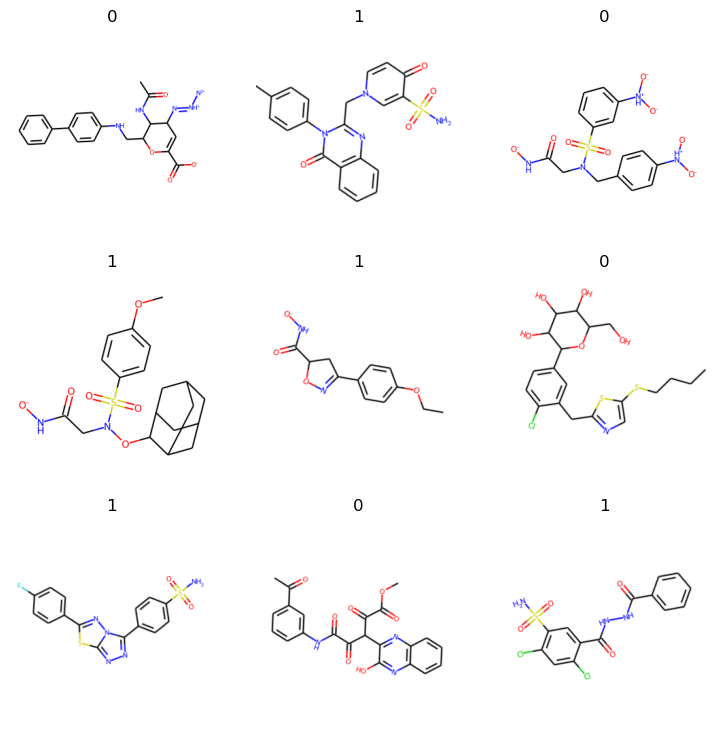

In [21]:
dls.show_batch()

# Train a CNN

In [22]:
from utils import plot_metrics

We use a pretrained resnet18 model as before, only adding a custom "head" to the model that outputs 128 features (to have fewer activations in the final hidden layer):

In [23]:
resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
custom_head = create_head(nf=512, n_out=2, lin_ftrs=[128], concat_pool=True)

In [25]:
custom_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=128, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=128, out_features=2, bias=False)
)

In [26]:
learn = vision_learner(dls,                             
                arch=resnet18, pretrained=True,  
                custom_head=custom_head,
                wd=2e-4, ps=0.8,                    
                metrics=[accuracy,                  
                         F1Score(), 
                         Precision(), 
                         Recall(), 
                         RocAucBinary(), 
                         MatthewsCorrCoef()],
                cbs=[ShowGraphCallback()])

/home/ubuntu/anaconda3/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

The below training takes a while. We can rather load the results of a previous run:

In [ ]:
learn = learn.load('chembl205-model-test-hooks')

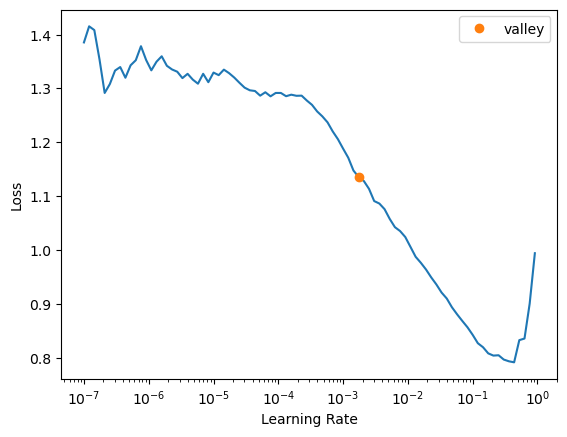

In [28]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.363106,0.242644,0.924209,0.685767,0.550445,0.909314,0.969280,0.671955,00:30
1,0.203242,0.152120,0.949175,0.766393,0.658451,0.916667,0.980950,0.751474,00:31
2,0.160120,0.144431,0.954079,0.788066,0.679078,0.938725,0.983799,0.775646,00:31
3,0.127665,0.107596,0.967454,0.837054,0.768443,0.919118,0.985272,0.823188,00:31
4,0.110626,0.114623,0.964333,0.823009,0.750000,0.911765,0.982896,0.808125,00:31
5,0.100816,0.110200,0.967454,0.837778,0.766260,0.924020,0.986358,0.824304,00:31
6,0.090813,0.111119,0.967900,0.839286,0.770492,0.921569,0.986083,0.825678,00:31
7,0.083603,0.118944,0.970575,0.852349,0.783951,0.933824,0.986398,0.840093,00:31
8,0.069420,0.111246,0.970352,0.851728,0.781186,0.936275,0.987472,0.839636,00:31
9,0.063587,0.114067,0.970352,0.852058,0.780041,0.938725,0.987255,0.840165,00:31


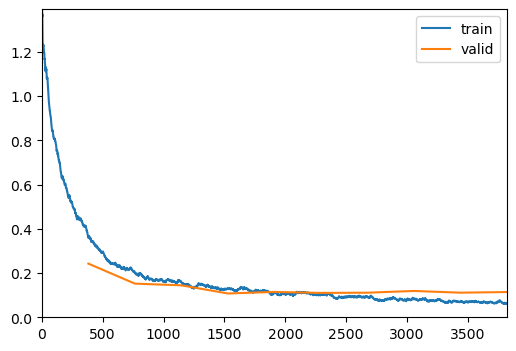

In [29]:
learn.fit_one_cycle(10, lr)

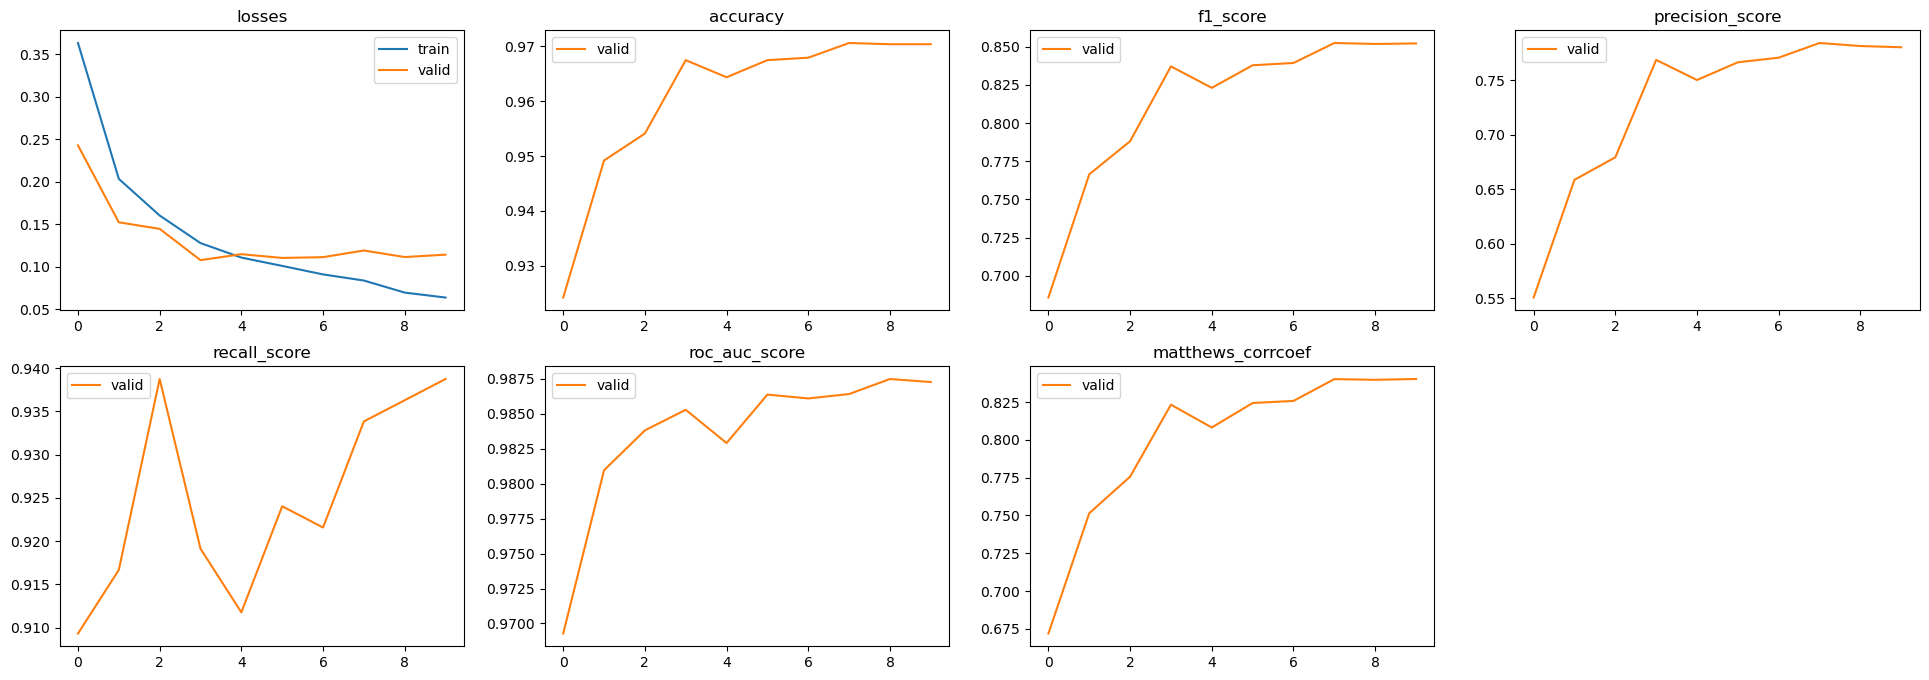

In [30]:
learn.recorder.plot_metrics()

In [31]:
learn.save('chembl205-model-test-hooks')

Path('models/chembl205-model-test-hooks.pth')

### Evaluate

In [32]:
interp = ClassificationInterpretation.from_learner(learn)

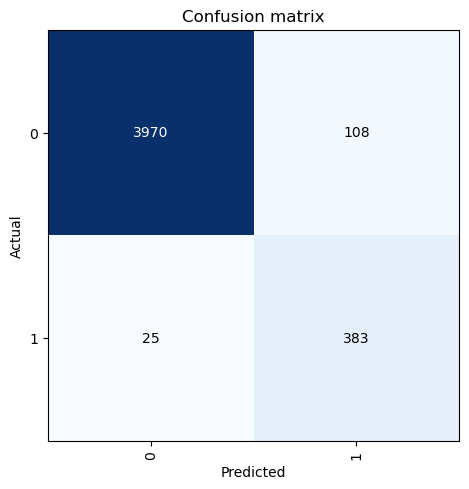

In [33]:
interp.plot_confusion_matrix()

# Save activations 

from second final layer. To be used to train a different ML model.

We need to register a **forward hook** at the layer we want to save activations from:

In [34]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [35]:
learn.model[-1][-5]

Linear(in_features=1024, out_features=128, bias=False)

In [36]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

Create the df again, this time with no oversampling (as that's not necessary).

In [37]:
df, name = get_df(ds)

df_nodupl = val_cols_and_oversample(df, oversample=False)

No data augmentation:

In [38]:
test_db = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=RandomSplitter(valid_pct=0.),
    item_tfms=None,
    batch_tfms=None
    )

We can feed one image at a time throught the model to get the activations

In [39]:
test_dls = test_db.dataloaders(df_nodupl, bs=1)

In [40]:
test_df = test_dls.items.reset_index()

In [41]:
test_df.head()

,index,CID,SMILES,Image,Activity,is_valid
0,6726,CHEMBL386242,Fc1c2OCC([NH+](CCCc3c4cc(F)ccc4[nH]c3)C)Cc2c(cc1)C(=O)N,CHEMBL386242.png,0,False
1,3926,CHEMBL1807603,O=C(NCC[NH+]1CCCC1)c1ccc(cc1)-c1n2[NH2+][C-](NCC3CC3)C=Cc2nc1,CHEMBL1807603.png,0,False
2,2278,CHEMBL573257,o1c(ccc1C)-c1cc2c(occ2-c2ccc(cc2)C(=O)[O-])cc1,CHEMBL573257.png,0,False
3,5493,CHEMBL128327,S(=O)(=O)(N1CCC2(CCc3c2cccc3)CC1)CC12CCC(CC1NC(=O)c1nc[nH]c1C)C2(C)C,CHEMBL128327.png,0,False
4,9660,CHEMBL519770,S(=O)(=O)(N(Cc1c(nc2c(cccc2)c1C(=O)NC(CC)c1ccccc1)-c1cc(F)ccc1)C)C,CHEMBL519770.png,0,False


Each element of the dataset consists of an image (a `PILImage`) and a category (the corresponding activity label):

In [42]:
test_dls.dataset[0]

(PILImage mode=RGB size=300x300, TensorCategory(0))

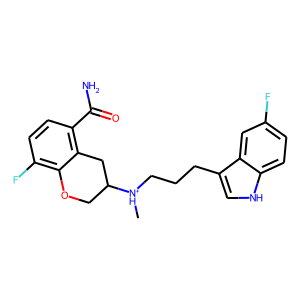

In [43]:
test_dls.dataset[0][0]

In [44]:
def get_data(CID):
    idx = test_df.loc[test_df.CID==CID].index[0]
    print(idx)
    return test_dls.dataset[idx]

In [45]:
def get_activations(CID):
    idx = df_nodupl.loc[df_nodupl.CID == CID].index[0]
    data = get_data(CID)
    img = data[0]
    
    with torch.no_grad(): 
        output = learn.predict(img)
    acts = np.array(hook_output.stored.cpu())[0]

    return list(acts)

The below computation takes a while.. We can rather load results computed earlier:

In [49]:
df_acts = pd.read_csv('local_data/chembl205_cnn_activations.csv')

In [46]:
%%time
%%capture
df_nodupl['activations'] = df_nodupl.CID.apply(get_activations)

CPU times: user 3h 11min 33s, sys: 13min 29s, total: 3h 25min 3s
Wall time: 6min 24s


Now we've stored activations for each image:

In [47]:
df_nodupl.head()

,CID,SMILES,Image,Activity,is_valid,activations
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,CHEMBL188002.png,1,True,"[-2.299679, 0.39197934, -1.3222568, 3.9510002, 2.9922621, -0.85782206, -3.9806352, -0.7120335, -6.093421, 7.84376, 9.940614, -11.164562, 4.798587, 10.668949, 0.7518735, 6.435635, 3.5374947, -1.7338138, -10.900384, 5.403385, -0.70138097, 2.0508866, -1.2508228, 0.8612398, -1.0183438, 2.950882, -1.3861161, 6.3743057, -1.0060135, 5.228385, 6.4881263, 6.794259, -4.909926, 2.1372442, 4.8994226, 2.4861727, 0.40870202, -1.5576589, -1.5495255, -1.1128128, -6.4313793, 6.763011, -6.5801587, 0.5208886, 4.443953, -2.1659555, 0.70892596, 1.7266028, -7.012219, 10.503553, -4.0241013, -2.8436823, 3.169609,..."
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,CHEMBL364127.png,1,False,"[-6.442596, -1.3277328, -6.4856787, -7.3775215, -2.7240622, 8.338077, 5.125438, -3.17337, -4.3458643, 2.6451123, 1.1456246, -2.4986696, -4.844792, -5.4722967, -1.8080281, 1.3713548, -5.0546246, 4.7875586, -3.905463, -0.56775117, -3.1755757, -12.689299, -7.5868044, 0.052794933, -4.4179974, -0.081925035, -0.463534, 0.3194841, -8.053915, -3.5133338, -2.2901402, -1.5455022, 5.237805, -2.0685687, -7.7054415, -5.7294607, 0.25232732, -7.404992, 5.8886685, -5.036751, -8.657858, -2.5198247, -1.9862447, 2.9211092, -5.8741016, -0.07320142, 7.2279205, -9.28678, 1.2912925, 5.914234, -2.373721, -3.08093..."
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,CHEMBL1683469.png,1,False,"[-8.9267845, -2.0370421, -2.4014297, -2.602699, -0.43833363, 10.670082, 7.32913, -6.0847425, -6.465829, 3.7205129, 3.829645, 0.63078654, -2.2764015, -2.6543865, -1.84741, -0.03756386, -6.978673, 8.911278, -0.33167493, -1.7710297, -2.430461, -8.967742, -4.1138062, -4.721642, -1.7920468, -3.1143503, 1.614712, -3.767741, -4.8922405, -3.411355, -4.86157, 3.2234726, 5.0720015, -8.154968, -6.182869, -8.343106, 8.511473, -1.5720547, 0.09458965, -2.4724658, -9.414514, -2.658036, -3.1127942, -7.356542, 0.32318228, 1.4556949, 8.997476, -4.467837, 0.17845559, 6.003296, -3.2791893, 2.8624241, -9.21892..."
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],CHEMBL52564.png,1,False,"[-9.359317, 6.2528296, -2.077129, -5.785701, -0.9776076, -9.607999, -3.7837722, -3.3297133, -2.7526135, -9.33432, -9.49161, 11.970671, -3.9982271, -2.805742, 4.923605, -6.617649, -4.770154, -5.877884, 8.155616, -8.296173, -2.4819384, -7.2435603, -1.8196046, 1.6433706, -6.7733192, 6.8755617, -6.143832, 4.014247, -5.745476, -2.9950094, -5.2301216, -11.620118, 5.141185, -13.601574, -5.8443975, -3.4397604, -8.995794, -1.8347974, 9.132387, 1.3703504, -1.5006351, -5.8497396, 3.0565794, 10.225879, -0.35886335, 8.721269, -7.602734, -0.7560338, 8.609535, -9.347555, -2.6480904, 5.562838, -5.6465955,..."
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,CHEMBL21427.png,1,False,"[-7.231392, 6.987898, 1.7854731, -2.5246212, 2.5871468, -5.562439, -0.978333, -6.4095325, -2.0669508, -6.228631, -13.029089, 7.303077, -0.60870886, -4.858076, 7.8678136, 0.89630526, -2.8521714, -0.27766037, 10.520813, -5.463057, -3.211698, -2.2753701, 0.39512014, -3.9536042, -6.929287, 3.4058716, -5.4407625, -3.3445375, -2.0299482, -5.694636, -5.8470592, -9.800745, 7.67161, -12.306686, -3.3317432, -8.761983, -3.1169631, -1.3503225, 5.0871534, -2.1644895, -0.7719948, -8.685864, 0.36492705, 4.015424, -0.8320061, 4.75517, -13.165645, -1.9238646, 5.2596703, -9.624714, -0.60909575, 8.39175, -2...."


We split the activations to have one column for each, as they will be treated as separate features later:

In [48]:
df_acts = pd.concat([df_nodupl, pd.DataFrame(df_nodupl.activations.values.tolist()).add_prefix('act_')], axis=1)

In [49]:
df_acts.drop('activations', axis=1, inplace=True)

Here's the result:

In [50]:
df_acts.head()

,CID,SMILES,Image,Activity,is_valid,act_0,act_1,act_2,act_3,act_4,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,CHEMBL188002.png,1,True,-2.299679,0.391979,-1.322257,3.951000,2.992262,...,8.658786,2.907712,-4.247343,-10.523098,-0.178129,12.424375,-8.630991,-1.846016,1.502652,6.465694
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,CHEMBL364127.png,1,False,-6.442596,-1.327733,-6.485679,-7.377522,-2.724062,...,6.478604,4.289104,1.920453,2.991122,-2.838840,2.205130,3.870908,-10.107666,3.076044,5.606683
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,CHEMBL1683469.png,1,False,-8.926785,-2.037042,-2.401430,-2.602699,-0.438334,...,7.562694,-0.693500,-1.373296,3.524506,-0.967370,4.518978,-3.316400,-6.973338,9.994685,0.087603
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],CHEMBL52564.png,1,False,-9.359317,6.252830,-2.077129,-5.785701,-0.977608,...,-3.988025,-4.006131,3.790591,8.814764,9.627171,-13.998599,5.761904,-7.941637,7.687120,-8.617470
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,CHEMBL21427.png,1,False,-7.231392,6.987898,1.785473,-2.524621,2.587147,...,-5.971627,-3.433340,5.300729,10.588403,11.922306,-12.068555,4.393377,-2.782949,7.491778,-6.219052


In [51]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 133 entries, CID to act_127
dtypes: float32(128), int64(1), object(4)
memory usage: 9.4+ MB


In [52]:
df_acts.to_csv('data/chembl205_with_cnn_activations.csv', index=None)

# Add molecular fingerprints

When training the random forest below, we'll compare the results obtained by using _molecular fingerprints_ as features describing molecules. See the notebook `0.1.0-representations-get_molecular_fingerprints_and_images.ipynb` for the code to generate fingerprints.

In [55]:
df_ecfp = pd.read_csv(INTERIMDATA/'CHEMBL205_cl_ecfp_1024.csv')

In [56]:
df_ecfp.head()

,CID,SMILES,Activity,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,ECFP4_1015,ECFP4_1016,ECFP4_1017,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
df_ecfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 1027 entries, CID to ECFP4_1024
dtypes: int64(1025), object(2)
memory usage: 140.6+ MB


In [58]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17941 entries, 0 to 17940
Columns: 133 entries, CID to act_127
dtypes: float32(128), int64(1), object(4)
memory usage: 9.4+ MB


In [59]:
df = df_ecfp.merge(df_acts, on='CID')

In [60]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,0,0,0,0,0,0,0,...,8.658786,2.907712,-4.247343,-10.523098,-0.178129,12.424375,-8.630991,-1.846016,1.502652,6.465694
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,0,0,0,0,0,0,0,...,6.478604,4.289104,1.920453,2.991122,-2.838840,2.205130,3.870908,-10.107666,3.076044,5.606683
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,0,0,0,0,0,0,0,...,7.562694,-0.693500,-1.373296,3.524506,-0.967370,4.518978,-3.316400,-6.973338,9.994685,0.087603
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,0,0,0,0,0,0,0,...,-3.988025,-4.006131,3.790591,8.814764,9.627171,-13.998599,5.761904,-7.941637,7.687120,-8.617470
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,0,0,0,0,0,0,0,...,-5.971627,-3.433340,5.300729,10.588403,11.922306,-12.068555,4.393377,-2.782949,7.491778,-6.219052


In [61]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [62]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,0,0,0,0,0,0,0,...,8.658786,2.907712,-4.247343,-10.523098,-0.178129,12.424375,-8.630991,-1.846016,1.502652,6.465694
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,0,0,0,0,0,0,0,...,6.478604,4.289104,1.920453,2.991122,-2.838840,2.205130,3.870908,-10.107666,3.076044,5.606683
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,0,0,0,0,0,0,0,...,7.562694,-0.693500,-1.373296,3.524506,-0.967370,4.518978,-3.316400,-6.973338,9.994685,0.087603
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,0,0,0,0,0,0,0,...,-3.988025,-4.006131,3.790591,8.814764,9.627171,-13.998599,5.761904,-7.941637,7.687120,-8.617470
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,0,0,0,0,0,0,0,...,-5.971627,-3.433340,5.300729,10.588403,11.922306,-12.068555,4.393377,-2.782949,7.491778,-6.219052


In [63]:
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

Save the dataframe:

In [64]:
df.to_csv(INTERIMDATA/'chembl205-data-with-ecfp-activations.csv', index=None)

# Train machine learning models using extracted representations

Now we can combine the representations of our molecules + classification task with another representation: the ECFP fingerprints. This combined representation of our data can then, e.g., be used to train other machine learning models.

### Split the data

We use the validation data from the CNN model as test data (as it's unseen by the CNN model during training).

In [65]:
train = df.loc[df.is_valid==False]
test = df.loc[df.is_valid==True]

In [66]:
X_train, y_train = train.drop(["CID", "SMILES", "Activity", "Image"], axis=1), train["Activity"]

In [67]:
X_test, y_test = test.drop(["CID", "SMILES", "Activity", "Image"], axis=1), test["Activity"]

In [68]:
X_train.head()

,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,ECFP4_9,ECFP4_10,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
1,0,0,0,0,0,0,0,0,0,0,...,6.478604,4.289104,1.920453,2.991122,-2.838840,2.205130,3.870908,-10.107666,3.076044,5.606683
2,0,0,0,0,0,0,0,0,0,0,...,7.562694,-0.693500,-1.373296,3.524506,-0.967370,4.518978,-3.316400,-6.973338,9.994685,0.087603
3,0,0,0,0,0,0,0,0,0,0,...,-3.988025,-4.006131,3.790591,8.814764,9.627171,-13.998599,5.761904,-7.941637,7.687120,-8.617470
4,0,0,0,0,0,0,0,0,0,0,...,-5.971627,-3.433340,5.300729,10.588403,11.922306,-12.068555,4.393377,-2.782949,7.491778,-6.219052
5,0,0,0,0,0,0,0,0,0,0,...,0.331396,-2.116879,5.774861,4.017020,17.601240,-13.691666,0.008295,-5.685153,12.029903,-8.471056


In [69]:
y_train.head()

1    1
2    1
3    1
4    1
5    1
Name: Activity, dtype: int64

### Logistic Regression and Random forest

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [71]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, 
matthews_corrcoef, precision_score, f1_score

In [119]:
def get_scores(y_test, y_pred, y_pred_prob):
    temp=[]
    for j in range(len(y_pred_prob)):
        temp.append(y_pred_prob[j][1])
    
    auc=roc_auc_score(np.array(y_test),np.array(temp))
    acc2=accuracy_score(y_test,y_pred)
    mcc=matthews_corrcoef(y_test,y_pred)
    recall=recall_score(y_test, y_pred,pos_label=1)
    precision=precision_score(y_test, y_pred,pos_label=1)
    F1_score=f1_score(y_test, y_pred,pos_label=1)
    
    print(f"AUC: {auc.round(5)}, Acc: {acc2.round(5)}, MCC: {mcc.round(5)}")
    print(f"Recall: {recall.round(5)}, Precision: {precision.round(5)}, F1_score: {F1_score.round(5)}")
    
    return auc, acc2, mcc, recall, precision, F1_score

In [116]:
def train_lr(X_train, X_test, y_train, y_test, features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Must scale the data for the linear logreg model:
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.transform(X_test)
    
    
    lr = LogisticRegression(max_iter=500)
  
    lr.fit(X_train_std, y_train)
    
    y_pred = lr.predict(X_test_std)
    y_pred_prob = lr.predict_proba(X_test_std)
    
    auc, acc2, mcc, recall, precision, F1_score = get_scores(y_test, 
                                                             y_pred, 
                                                             y_pred_prob)
    

    return auc,acc2,mcc,recall,precision,F1_score, lr

In [123]:
def train_svc(X_train, X_test, y_train, y_test, features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Must scale the data for the linear logreg model:
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.transform(X_test)
    
    
    svc = SVC(probability=True, random_state=42)
  
    svc.fit(X_train_std, y_train)
    
    y_pred = svc.predict(X_test_std)
    y_pred_prob = svc.predict_proba(X_test_std)

    auc, acc2, mcc, recall, precision, F1_score = get_scores(y_test, 
                                                             y_pred, 
                                                             y_pred_prob)
    


    return auc,acc2,mcc,Recall,Precision,F1_score, svc

In [88]:
def train_rf(X_train, X_test, y_train, y_test, n_estimators=100, 
             criterion='gini', max_features='log2', features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Following the settings in the paper, `RF_tune.py`
    rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, min_samples_split=2, 
                                    max_features=max_features, max_leaf_nodes=None, 
                                    bootstrap=False,oob_score=False, n_jobs=-1, 
                                    random_state=42)
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    y_pred_prob = rf.predict_proba(X_test)
    
    auc, acc2, mcc, recall, precision, F1_score = get_scores(y_test, 
                                                             y_pred, 
                                                             y_pred_prob)
    

    return auc,acc2,mcc,Recall,Precision,F1_score, rf

**Logistic regression:**

In [120]:
_ = train_lr(X_train, X_test, y_train, y_test, features='ECFP')

Training on 1024 features

AUC: 0.97651, Acc: 0.95497, MCC: 0.74018
Recall: 0.80147, Precision: 0.72991, F1_score: 0.76402


In [121]:
_ = train_lr(X_train, X_test, y_train, y_test, features='act_')

Training on 128 features

AUC: 0.98323, Acc: 0.96545, MCC: 0.78945
Recall: 0.80147, Precision: 0.81546, F1_score: 0.80841


In [122]:
_ = train_lr(X_train, X_test, y_train, y_test, features='all')

Training on all 1153 ECFP and CNN features

AUC: 0.98154, Acc: 0.96456, MCC: 0.78589
Recall: 0.80637, Precision: 0.8044, F1_score: 0.80539


**Support vector machine classifier:**

In [124]:
_ = train_svc(X_train, X_test, y_train, y_test, features='ECFP')

Training on 1024 features

AUC: 0.98965, Acc: 0.97615, MCC: 0.85497
Recall: 0.86275, Precision: 0.87345, F1_score: 0.86806


In [125]:
_ = train_svc(X_train, X_test, y_train, y_test, features='act_')

Training on 128 features

AUC: 0.96663, Acc: 0.97236, MCC: 0.83841
Recall: 0.88235, Precision: 0.82569, F1_score: 0.85308


In [126]:
_ = train_svc(X_train, X_test, y_train, y_test, features='all')

Training on all 1153 ECFP and CNN features

AUC: 0.98504, Acc: 0.97548, MCC: 0.85634
Recall: 0.89706, Precision: 0.84332, F1_score: 0.86936


**Random forest:**

In [89]:
_ = train_rf(X_train, X_test, y_train, y_test, features='ECFP')

Training on 1024 features

AUC: 0.992, Acc: 0.97459, MCC: 0.84206
Recall: 0.82598, Precision: 0.88684, F1_score: 0.85533


In [90]:
_ = train_rf(X_train, X_test, y_train, y_test, features='act_')

Training on 128 features

AUC: 0.97817, Acc: 0.97191, MCC: 0.8309
Recall: 0.85049, Precision: 0.84223, F1_score: 0.84634


In [91]:
_ = train_rf(X_train, X_test, y_train, y_test, features='all')

Training on all 1153 ECFP and CNN features

AUC: 0.98361, Acc: 0.97169, MCC: 0.83053
Recall: 0.85539, Precision: 0.83693, F1_score: 0.84606
